In [3]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

2021-12-07 11:33:05.678353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-07 11:33:05.678375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=-1) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Creating placeholder lists
    X, Y = [], []

    for i in range(len(ts) - lag - n_ahead):
        Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
        # X.append(ts[i:(i + lag)])

    ts = np.delete(ts, -1, axis=1)
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    if len(ts) - lag <= 0:
        X.append(np.concatenate(ts))
    else:
        for i in range(len(ts) - lag - n_ahead):
            X.append(np.concatenate(ts[i+1:(i + lag + 1)]))

    X = np.array(X)
    Y = np.array(Y)

    # Reshaping the X array to an RNN input shape 
    # X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [5]:
df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
df2005.index = pd.to_datetime(df2005.Date, format="%d.%m.%Y")
df2005 = df2005.drop(['Date'], axis=1)

df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
df2006.index = pd.to_datetime(df2006.Date, format="%d.%m.%Y")
df2006 = df2006.drop(['Date'], axis=1)

print(f'Shape of data 2005: {df2005.shape}')
print(f'Shape of data 2006: {df2006.shape}')

df = pd.concat([df2005, df2006], axis=0)
# df = df.fillna(0)

Shape of data 2005: (165, 5)
Shape of data 2006: (165, 5)


In [6]:
# Share of obs in testing 
test_share = 0.2

# The features used in the modeling 
# features_final = ['Avg', 'Dev', 'Rain', 'DD', 'DD Sum', 'CountTrap1', 'CountTrap2', 'CountTrap3', 'Sum']
features_final = ['Avg', 'DDSum', 'Rain', 'Sum_trap']

In [7]:
ts = df[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
# train_mean = train.mean()
# train_std = train.std()

# train = (train - train_mean) / train_std
# test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])
ts_s

,Avg,DDSum,Rain,Sum_trap
Date,,,,
2005-05-01,12.93,32.13,0.0,0.0
2005-05-02,15.07,37.21,0.0,0.0
2005-05-03,16.30,43.51,3.0,0.0
2005-05-04,13.23,46.74,6.1,0.0
2005-05-05,9.33,46.74,23.0,0.0
...,...,...,...,...
2006-10-08,11.54,1149.50,0.0,0.0
2006-10-09,11.44,1150.94,0.0,0.0
2006-10-10,10.61,1151.55,0.0,0.0


In [8]:
# Number of lags to use for models
lag = 10
# Steps ahead to forecast 
n_ahead = 5

X, y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)
X_train = X[int(0.2*len(X)):]
y_train = y[int(0.2*len(X)):]
X_test = X[:int(0.2*len(X))]
y_test = y[:int(0.2*len(y))]


In [9]:
print(X.shape, y.shape)
print(X_train.shape, X_test.shape)

(315, 30) (315, 5)
(252, 30) (63, 30)


In [10]:
def get_model(n_inputs, n_outputs, n_neurons):
	model = Sequential()
	model.add(Dense(n_neurons, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_neurons/2, input_dim=n_neurons, kernel_initializer='he_uniform', activation='elu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='rmsprop')
	return model

In [11]:
def evaluate_model(X_train, y_train):
	n_neurons = 10
	results = list()
	n_inputs, n_outputs = X.shape[1], y.shape[1]
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs, n_neurons)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

In [12]:
# results = evaluate_model(X, y)

In [13]:
# print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

In [14]:
# use mlp for prediction on multi-output regression
from numpy import asarray

In [15]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
n_neurons = 46
# get model
model = get_model(n_inputs, n_outputs, n_neurons)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=1000)
# make a prediction for new data
row = X_test[14]
newX = asarray([row])
yhat = model.predict(newX)
print('Predicted: %s' % yhat[0])

2021-12-07 11:33:29.714168: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-07 11:33:29.714219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ligerd-OMEN-25L-Desktop-GT12-0xxx): /proc/driver/nvidia/version does not exist
2021-12-07 11:33:29.715183: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Predicted: [2.7633753 3.3637884 2.5624487 1.2920231 2.0718727]


In [16]:
y_test[14]

array([ 6. ,  4. , 12. , 14.5, 17. ])

In [17]:
yhat = [x[0] for x in model.predict(X_test)]
yorg = [y[0] for y in y_test]

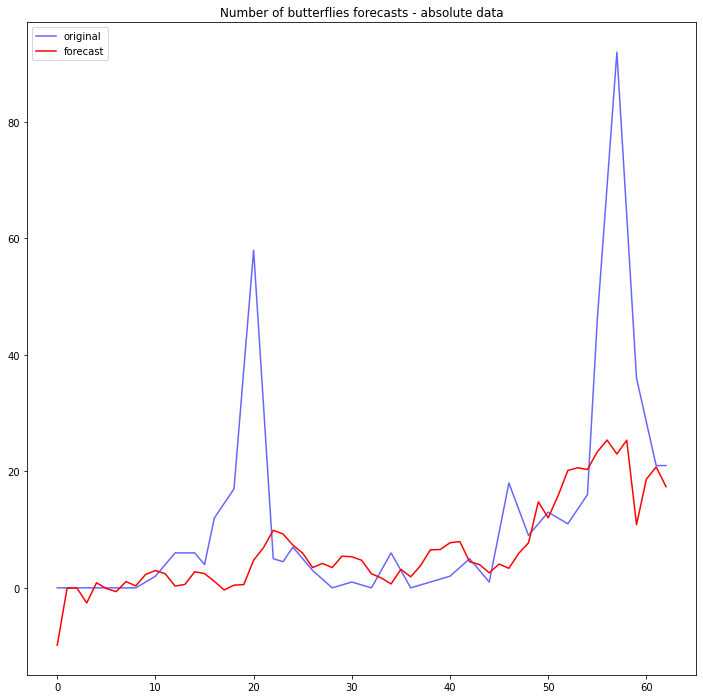

In [18]:
plt.figure(figsize=(12, 12))
plt.plot(range(len(yhat)), yorg, color='blue', label='original', alpha=0.6)
plt.plot(range(len(yhat)), yhat, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data')
plt.legend()
plt.show()

In [19]:
yhat = [x[0] for x in model.predict(X_train)]
yorg = [y[0] for y in y_train]

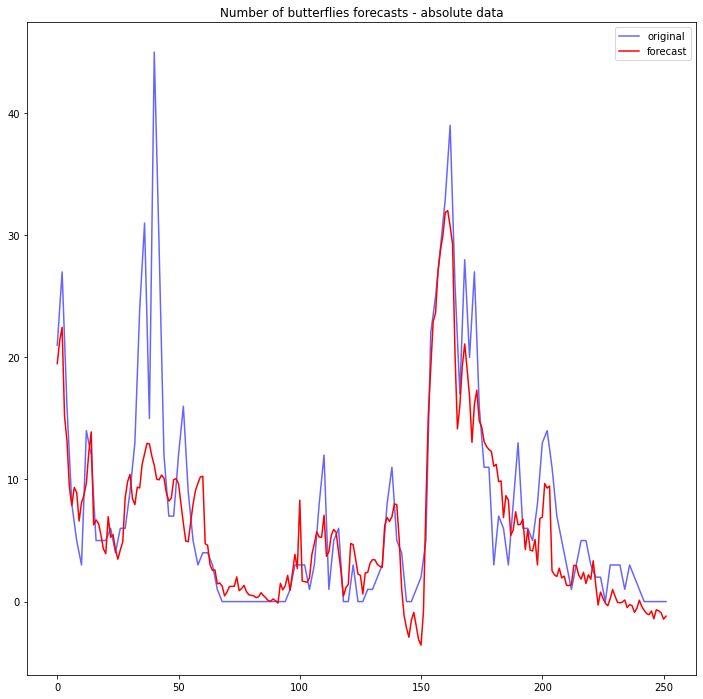

In [20]:
plt.figure(figsize=(12, 12))
plt.plot(range(len(yhat)), yorg, color='blue', label='original', alpha=0.6)
plt.plot(range(len(yhat)), yhat, color='red', label='forecast')
plt.title('Number of butterflies forecasts - absolute data')
plt.legend()
plt.show()